The file 'remove_beh.npy' is constructed in the RemovingBehaviorSubspaceWithPCA.ipynb. We check which principal components are correlated with behavior and drop them.These are the top 8 PC's. The rest of 3000 PC's are used to reconstruct the matrix. The behavior subspaces explain approximately 5 % of the variance and the rest of the PC's 80% of the variance. Let's see what happens when we fit EP to this data.

In [1]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import zscore
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter, gaussian_filter1d
import sys
sys.path.insert(1, '/home/maria/Documents/EnsemblePursuit')
from EnsemblePursuit.EnsemblePursuit import EnsemblePursuit

In [2]:
S=np.load('remove_beh.npy')

In [12]:
dt=1
spks= np.load(data_path+'spks.npy')
iframe = np.load(data_path+'iframe.npy') # iframe[n] is the microscope frame for the image frame n
ivalid = iframe+dt<spks.shape[-1] # remove timepoints outside the valid time range
iframe = iframe[ivalid]
del spks

In [8]:
data_path='/media/maria/DATA1/Documents/data_for_suite2p/TX39/'

In [4]:
ep=EnsemblePursuit(n_components=200,lam=0.01,n_kmeans=200)
model=ep.fit(S.T[:10000,:])
V=model.components_
U=model.weights

obtained 200 PCs in 14.9093 seconds
initialized 200 clusters with k-means in 14.1456 seconds
ensemble 0, time 24.23, nr neurons 13875, EV 0.0790
ensemble 25, time 190.82, nr neurons 2876, EV 0.2922
ensemble 50, time 275.03, nr neurons 1193, EV 0.3445
ensemble 75, time 340.34, nr neurons 585, EV 0.3750
ensemble 100, time 397.17, nr neurons 350, EV 0.3966
ensemble 125, time 449.84, nr neurons 315, EV 0.4139
ensemble 150, time 499.02, nr neurons 501, EV 0.4274
ensemble 175, time 546.85, nr neurons 425, EV 0.4389
ensemble 199, time 589.67, nr neurons 158, EV 0.4479
average sparsity is 0.0604


In [5]:
print(U.shape)
print(V.shape)

(18795, 200)
(10000, 200)


In [6]:
def train_test_split(NT):
        nsegs = 20
        nt=NT
        nlen  = nt/nsegs
        ninds = np.linspace(0,nt-nlen,nsegs).astype(int)
        itest = (ninds[:,np.newaxis] + np.arange(0,nlen*0.25,1,int)).flatten()
        itrain = np.ones(nt, np.bool)
        itrain[itest] = 0
        return itrain, itest

In [14]:
mov=np.load(data_path+'mov.npy')
mov = mov[:, :, ivalid]
Sp = V.T
Sp = zscore(Sp, axis=1)
ly, lx, nstim = mov.shape
#print(nstim)
NT = Sp.shape[1]
mov=mov[:,:,:NT]

NN=Sp.shape[0]
print(NT)
itrain,itest=train_test_split(NT)

X = np.reshape(mov, [-1, NT]) # reshape to Npixels by Ntimepoints
X = X-0.5 # subtract the background
X = np.abs(X) # does not matter if a pixel is black (0) or white (1)
X = zscore(X, axis=1)/NT**.5  # z-score each pixel separately
npix = X.shape[0]

lam = 0.1
ncomps = Sp.shape[0]
B0 = np.linalg.solve((X[:,itrain] @ X[:,itrain].T + lam * np.eye(npix)),  (X[:,itrain] @ Sp[:,itrain].T)) # get the receptive fields for each neuron

B0 = np.reshape(B0, (ly, lx, ncomps))
B0 = gaussian_filter(B0, [.5, .5, 0]) # smooth each receptive field a little

10000


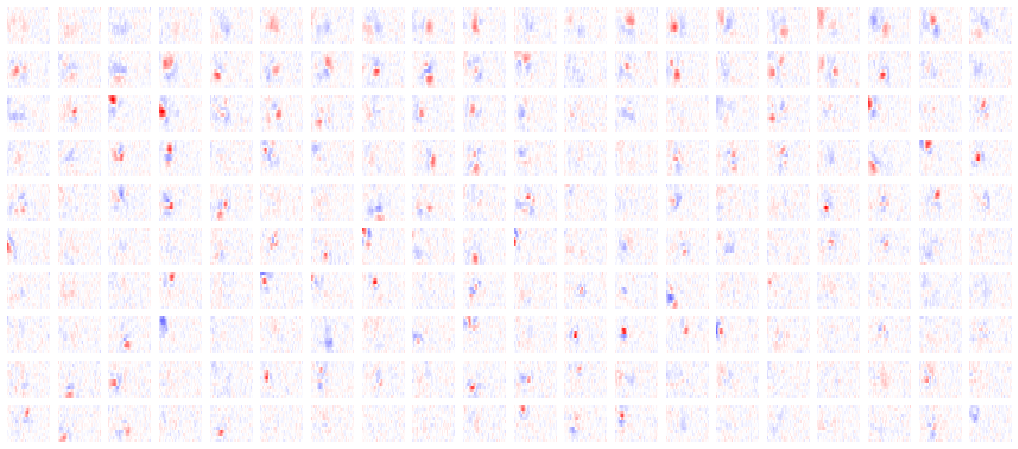

In [15]:
plt.figure(figsize=(18, 8))
rfmax = np.max(B0)
for j in range(200):
    plt.subplot(10,20,j+1)
    rf = B0[:,:,j]
    # rfmax = np.max(np.abs(rf))
    plt.imshow(rf, aspect='auto', cmap = 'bwr', vmin = -rfmax, vmax = rfmax) # plot the receptive field for each neuron
    #plt.title('PC %d'%(1+j))
    plt.axis('off')

plt.show()

In [16]:
Spred = np.reshape(B0, (-1,NN)).T @  X[:,itest]

corr_lst=[]
nr_of_components=200
for j in range(0,nr_of_components):
    corr_lst.append(np.corrcoef(Sp[j,itest],Spred[j,:])[0,1])

In [17]:
stat = np.load((data_path+'stat.npy'), allow_pickle=True) # these are the per-neuron stats returned by suite2p
# these are the neurons' 2D coordinates
ypos = np.array([stat[n]['med'][0] for n in range(len(stat))]) 
# (notice the python list comprehension [X(n) for n in range(N)])
xpos = np.array([stat[n]['med'][1] for n in range(len(stat))]) 

(array([ 4.,  7., 13., 15., 16., 16., 28., 44., 43., 14.]),
 array([ 59.28655115,  99.36663884, 139.44672653, 179.52681423,
        219.60690192, 259.68698961, 299.7670773 , 339.84716499,
        379.92725269, 420.00734038, 460.08742807]),
 <a list of 10 Patch objects>)

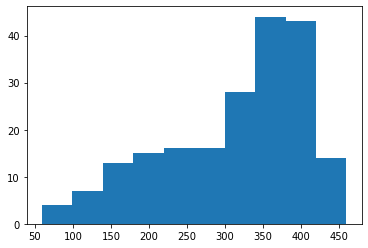

In [18]:
y_lst=[]
for comp in range(nr_of_components):
    nonz=np.nonzero(U[:,comp])[0]
    y_lst.append(np.std(ypos[nonz]))
plt.hist(y_lst)

(array([ 5.,  8., 13., 20., 24., 28., 49., 43.,  8.,  2.]),
 array([121.01023401, 179.56856211, 238.1268902 , 296.6852183 ,
        355.2435464 , 413.8018745 , 472.3602026 , 530.91853069,
        589.47685879, 648.03518689, 706.59351499]),
 <a list of 10 Patch objects>)

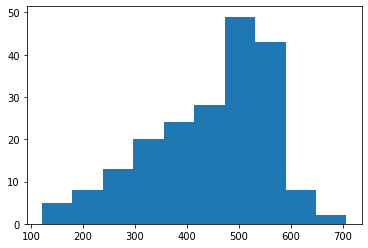

In [19]:
x_lst=[]
for comp in range(nr_of_components):
    nonz=np.nonzero(U[:,comp])[0]
    x_lst.append(np.std(xpos[nonz]))
plt.hist(x_lst)

Text(0.5, 0, 'Average spatial spread in x and y directions')

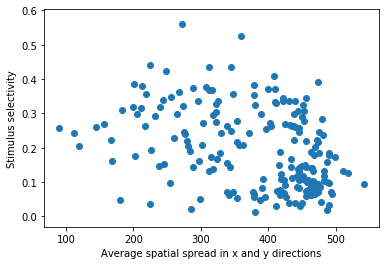

In [20]:
average_std=(np.array(x_lst)+np.array(y_lst))/2
plt.scatter(average_std,corr_lst)
plt.ylabel('Stimulus selectivity')
plt.xlabel('Average spatial spread in x and y directions')

In [21]:
proc = np.load(data_path+'cam1_TX39_2019_05_31_1_proc_resampled.npy', allow_pickle=True).item()
motSVD = proc['motSVD'][:,iframe+dt]
motSVD -= motSVD.mean(axis=1)[:,np.newaxis]
beh=motSVD[:,:10000]
covM = np.matmul(beh[:,itrain], beh[:,itrain].T)
lam = 1e5 # regularizer
covM += lam*np.eye(beh.shape[0])
A = np.linalg.solve(covM, np.matmul(beh[:,itrain], V.T[:,itrain].T))
Vpred = np.matmul(A.T, beh[:,itest])
beh_corr_lst=[]
for j in range(0,nr_of_components):
    beh_corr_lst.append(np.corrcoef(Vpred[j,:],V.T[j,itest])[0,1])

Text(0.5, 0, 'Average spatial spread in x and y directions')

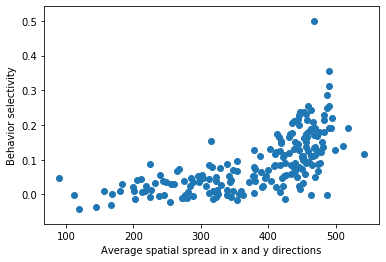

In [22]:
plt.scatter(average_std,beh_corr_lst)
plt.ylabel('Behavior selectivity')
plt.xlabel('Average spatial spread in x and y directions')

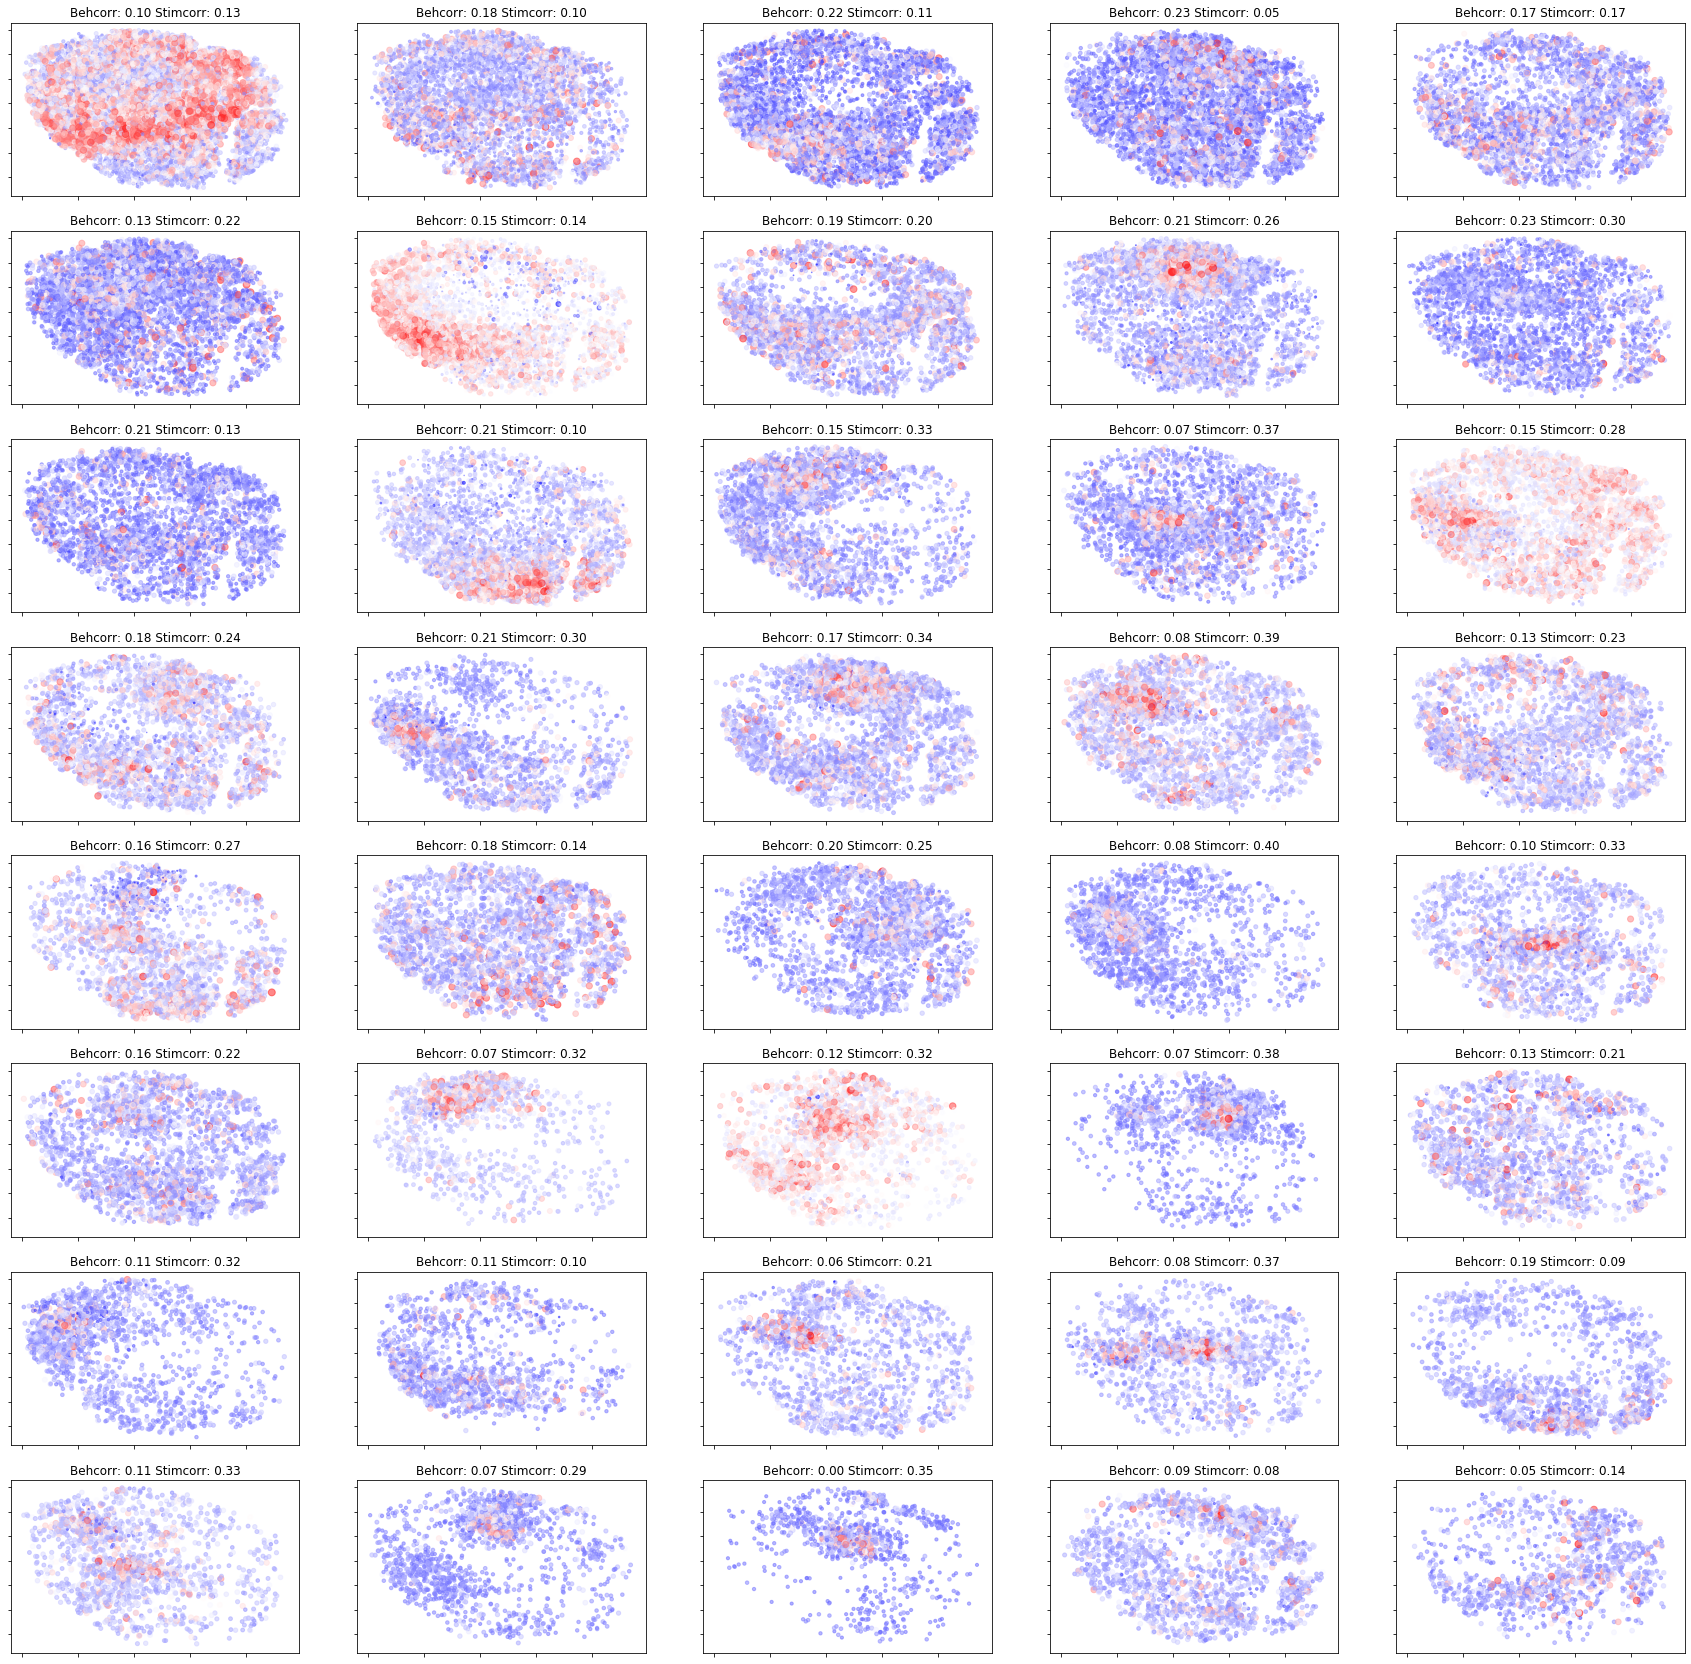

In [23]:
plt.figure(figsize=(30,30))
for j in range(40):
    comp= U[:,j]
    comp= comp/np.max(np.abs(comp))
    lam = np.abs(comp)    
    ax=plt.subplot(8,5,1+j)
    plt.scatter(xpos, -ypos, s = 50 * lam, c = comp, cmap='bwr', alpha = .5)
    plt.title('Behcorr: '+str(beh_corr_lst[j])[0:4]+' Stimcorr: '+str(corr_lst[j])[:4])
    ax.set_yticklabels([])
    ax.set_xticklabels([])
    #plt.colorbar()